In [1]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageDraw
import os
import time
from tqdm import tqdm
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.ops import nms

In [2]:
# Load the data
frames_path = '/kaggle/input/crowd-counting/frames/frames'
images = np.load('/kaggle/input/crowd-counting/images.npy')
labels_df = pd.read_csv('/kaggle/input/crowd-counting/labels.csv')
labels = np.load('/kaggle/input/crowd-counting/labels.npy')

print(f'Images shape: {images.shape}')
print(f'Labels shape: {labels.shape}')
print('First few entries in labels:', labels[:5])

Images shape: (2000, 480, 640, 3)
Labels shape: (2000, 1)
First few entries in labels: [[35]
 [41]
 [41]
 [44]
 [41]]


In [3]:
# Custom Dataset
class CrowdDataset(Dataset):
    def __init__(self, images, labels, frames_path, transforms=None):
        self.images = images
        self.labels = labels
        self.frames_path = frames_path
        self.transforms = transforms

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.frames_path, f'seq_{idx+1:06d}.jpg')
        image = Image.open(image_path).convert("RGB")

        count = self.labels[idx][0]  # Extract the crowd count

        # Generate synthetic bounding boxes for each person
        boxes = []
        for _ in range(count):
            xmin = np.random.randint(0, image.width - 50)
            ymin = np.random.randint(0, image.height - 50)
            xmax = xmin + np.random.randint(30, 50)
            ymax = ymin + np.random.randint(30, 50)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = np.array(boxes)
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)  # All objects are crowd

        target = {}
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["labels"] = labels

        if self.transforms:
            image = self.transforms(image)
        return image, target

In [4]:
# Data transforms
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))  # Example augmentation
    return T.Compose(transforms)

In [5]:
# Split dataset into training and validation sets
dataset = CrowdDataset(images, labels, frames_path, get_transform(train=True))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))

# Load a pre-trained model and modify it for our dataset
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='DEFAULT')
num_classes = 2  # 1 class (crowd) + background

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# Replace the head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Training the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 159MB/s]


In [6]:
# Function to calculate mean absolute error
def mean_absolute_error(true_counts, pred_counts):
    return np.mean(np.abs(true_counts - pred_counts))

In [7]:
# Training loop with validation
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    train_counts = []
    train_preds = []

    start_time = time.time()

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            train_losses.append(losses.item())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            pbar.update(1)

    lr_scheduler.step()

    # Calculate training MAE after the epoch
    model.eval()
    with torch.no_grad():
        for images, targets in train_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)
            for output in outputs:
                pred_boxes = output['boxes']
                train_preds.append(len(pred_boxes))
            for target in targets:
                train_counts.append(len(target['boxes']))

    train_mae = mean_absolute_error(np.array(train_counts), np.array(train_preds))

    # Validation phase
    val_losses = []
    val_counts = []
    val_preds = []

    with torch.no_grad():
        for images, targets in val_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            for output in outputs:
                pred_boxes = output['boxes']
                val_preds.append(len(pred_boxes))

            for target in targets:
                val_counts.append(len(target['boxes']))

    # Calculate validation MAE
    val_mae = mean_absolute_error(np.array(val_counts), np.array(val_preds))

    elapsed_time = time.time() - start_time

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"{len(train_loader)}/{len(train_loader)} [==============================] - {elapsed_time:.0f}s - loss: {np.mean(train_losses):.4f} - mean_absolute_error: {train_mae:.4f} - val_loss: N/A - val_mean_absolute_error: {val_mae:.4f}")

    # Save the model
    torch.save(model.state_dict(), 'faster_rcnn_crowd.pth')

Epoch 1/10: 100%|██████████| 400/400 [06:40<00:00,  1.00s/batch]


Epoch 1/10
400/400 [==============================] - 625s - loss: 0.8570 - mean_absolute_error: 68.9988 - val_loss: N/A - val_mean_absolute_error: 68.2175


Epoch 2/10: 100%|██████████| 400/400 [06:44<00:00,  1.01s/batch]


Epoch 2/10
400/400 [==============================] - 629s - loss: 0.8080 - mean_absolute_error: 68.9988 - val_loss: N/A - val_mean_absolute_error: 68.2175


Epoch 3/10: 100%|██████████| 400/400 [06:46<00:00,  1.02s/batch]


Epoch 3/10
400/400 [==============================] - 630s - loss: 0.8117 - mean_absolute_error: 68.9988 - val_loss: N/A - val_mean_absolute_error: 68.2175


Epoch 4/10: 100%|██████████| 400/400 [06:45<00:00,  1.01s/batch]


Epoch 4/10
400/400 [==============================] - 629s - loss: 0.8033 - mean_absolute_error: 68.9988 - val_loss: N/A - val_mean_absolute_error: 68.2175


Epoch 5/10: 100%|██████████| 400/400 [06:45<00:00,  1.01s/batch]


Epoch 5/10
400/400 [==============================] - 629s - loss: 0.7927 - mean_absolute_error: 68.9988 - val_loss: N/A - val_mean_absolute_error: 68.2175


Epoch 6/10: 100%|██████████| 400/400 [06:45<00:00,  1.01s/batch]


Epoch 6/10
400/400 [==============================] - 630s - loss: 0.7881 - mean_absolute_error: 68.9988 - val_loss: N/A - val_mean_absolute_error: 68.2175


Epoch 7/10: 100%|██████████| 400/400 [06:45<00:00,  1.01s/batch]


Epoch 7/10
400/400 [==============================] - 630s - loss: 0.7935 - mean_absolute_error: 68.9988 - val_loss: N/A - val_mean_absolute_error: 68.2175


Epoch 8/10: 100%|██████████| 400/400 [06:45<00:00,  1.01s/batch]


Epoch 8/10
400/400 [==============================] - 630s - loss: 0.7956 - mean_absolute_error: 68.9988 - val_loss: N/A - val_mean_absolute_error: 68.2175


Epoch 9/10: 100%|██████████| 400/400 [06:45<00:00,  1.01s/batch]


Epoch 9/10
400/400 [==============================] - 630s - loss: 0.7967 - mean_absolute_error: 68.9988 - val_loss: N/A - val_mean_absolute_error: 68.2175


Epoch 10/10: 100%|██████████| 400/400 [06:45<00:00,  1.01s/batch]


Epoch 10/10
400/400 [==============================] - 630s - loss: 0.7958 - mean_absolute_error: 68.9988 - val_loss: N/A - val_mean_absolute_error: 68.2175


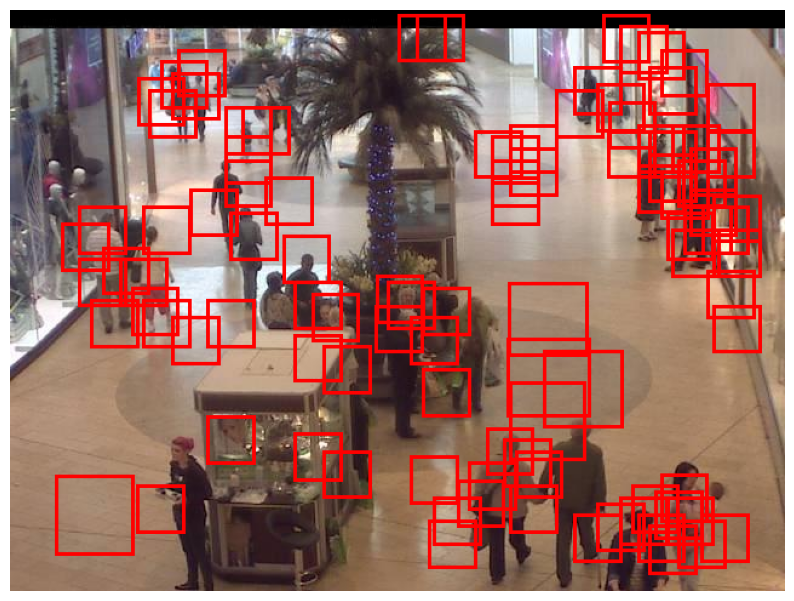

In [8]:
# Visualization function with NMS
def visualize_prediction_with_nms(image_path, model, device, nms_thresh=0.5):
    model.eval()
    image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)[0]

    # Apply NMS
    keep = nms(prediction['boxes'], prediction['scores'], nms_thresh)
    boxes = prediction['boxes'][keep]

    draw = ImageDraw.Draw(image)
    for box in boxes:
        draw.rectangle(box.tolist(), outline='red', width=3)

    # Save the image with bounding boxes
    image.save('prediction_with_nms.png')

    # Display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Example usage:
visualize_prediction_with_nms('/kaggle/input/crowd-counting/frames/frames/seq_000001.jpg', model, device, nms_thresh=0.5)

# Visualize synthetic data function
def visualize_synthetic_data(dataset, idx):
    image, target = dataset[idx]
    image = F.to_pil_image(image)
    draw = ImageDraw.Draw(image)
    for box in target['boxes']:
        draw.rectangle(box.tolist(), outline='red', width=3)
    image.show()

# Example usage to visualize synthetic data
visualize_synthetic_data(dataset, 0)